# Traitement des données d'un questionnaire

Ce notebook propose de suivre les différentes étapes de l'analyse des données d'une enquête par questionnaire.

L'enquête est passée par un prestataire, et les résultats sont transmis dans un fichier SPSS .sav

Les étapes du traitement sont alors :

1. Chargement et recodage
2. Nettoyage et exploration (1. et 2. sont itératifs)
3. Production de statistiques descriptives et de visualisations
4. Traitements statistiques plus avancées autour de certaines questions
5. Production de visualisations finalisées

Le Notebook permet de noter progressivement les idées de l'analyse.

**Pour les besoins pédagogique, la première partie de chargement suit un peu la démarche "progressive", avec un exemple de recodage, puis nous passerons rapidement sur le recodage de chaque variable.**

Le jeu de données sera celui du Wellcome Trust passé par Gallup à travers le monde pour connaître l'attitude vis-à-vis de la science. Une question générale est alors : retrouve-t-on les mêmes tendances dans tous les pays ?

Les données ainsi que le rapport sont disponibles ici : https://wellcome.org/reports/wellcome-global-monitor-covid-19/2020





## Etape 1. Chargement et recodage

In [2]:
# Il est possible de charger directement avec Pandas

import pandas as pd
import pyshs
import matplotlib.pyplot as plt

pd.read_spss("./data/wgm-full-wave2-public-file.sav")

# Ou d'utiliser Pyreadstat pour avoir aussi les méta-données
import pyreadstat
data, meta = pyreadstat.read_sav('./data/wgm-full-wave2-public-file.sav')
data.shape

(119088, 89)

Les métadonnées contiennent en particulier les labels associés aux numéros de catégories et l'explicitation des questions (par ex *meta.column_names_to_labels*).

Il est alors intéressant de définir deux petites fonctions qui permettent d'obtenir la question associée à une colonne et les labels associés

In [4]:
def question(v,meta):
    return meta.column_names_to_labels[v]

def modalites(v,meta):
    return meta.value_labels[meta.variable_to_label[v]]

# test
modalites("W1",meta)

{1.0: 'A lot',
 2.0: 'Some',
 3.0: 'Not much',
 4.0: 'Nothing at all',
 99.0: 'DK/Refused'}

A partir de là, il est possible d'explorer le jeu de données et de commencer à 1/ identifier les questions qui nous intéressent et 2/ recoder les variables

Dans le cas d'une réflexion qui porte sur le rapport à la science : 

Variables dépendantes d'intérêt:

- 'W1': 'How Much You Know About Science'
- 'W2': 'How Much You Understand the Meaning of Science and Scientists'
- 'W6': 'Trust Science'
- **'W7C': 'Leaders in National Govt Value Opinions/Expertise of Scientists'**
- 'W8': 'Work of Scientists Benefits People in (Country)',
- 'W9': 'Work of Scientists Benefits People Like You in (Country)',
- 'WP21768': 'Agree to Be Vaccinated if Coronavirus Vaccine Was Available at No Cost
- **'MH4A': 'Important for National Govt to Fund Research on Cancer'**
- 'MH4B': 'Important for National Govt to Fund Research on Anxiety/Depression'

Variables indépendantes :
- 'Age': 'Age',
- 'Gender': 'Gender',
- 'Education': 'Education Level',
- 'Household_Income': 'Per Capita Income Quintiles',
- 'Global11Regions': 'Global regions used in report analysis',
- 'wbi': 'Country income level -- World Bank most recent definition',
- 'Subjective_Income': 'Feelings About Household Income',
- 'EMP_2010': 'Employment Status'}
- 'W27': 'Used Social Media in Past 30 Days',
- 'W28': 'How Often Use Social Media',
- 'W29': 'How Often See Information About Health on Social Media',
- 'W30': 'Believe Science or Teachings of Your Religion',
- 'WP21757': 'Extent Life Has Been Affected by Coronavirus Situation
- Différents items sur la confiance : 'W5A': 'Trust People in Neighborhood',
 'W5B': 'Trust the National Government in This Country',
 'W5C': 'Trust Scientists in This Country',
 'W5D': 'Trust Journalists in This Country',
 'W5E': 'Trust Doctors and Nurses in This Country',
 'W5F': 'Trust People Who Work at Charitable Organizations or NGOs in This Country',
 'W5G': 'Trust Traditional Healers in This Country',

Par ailleurs, comme  souvent, c'est une enquête pondérée avec les poids : 'WGT'

### Regarder chaque variable pour la recoder comme on le souhaite

Cas de la place de la science dans la décision politique

In [5]:
data["W7C"].fillna("NA").value_counts()

2.0     43577
3.0     26857
1.0     22629
4.0     13795
99.0     9215
NA       3015
Name: W7C, dtype: int64

Il y a des valeurs nulles et les labels ne sont pas explicites

In [6]:
modalites("W7C",meta)

{1.0: 'A lot',
 2.0: 'Some',
 3.0: 'Not much',
 4.0: 'Not at all',
 99.0: 'DK/Refused'}

Un recodage dichotomique

In [10]:
data["relation_science_politiques"] = data["W7C"].replace({1:"1-A lot",2:"2-Some",3:"3-Not much or not at all",
                                                 4:"3-Not much or not at all",99:"4-NA"}).fillna("4-NA")

In [11]:
data["relation_science_politiques"].value_counts()

2-Some                      43577
3-Not much or not at all    40652
1-A lot                     22629
4-NA                        12230
Name: relation_science_politiques, dtype: int64

Autre variable, juste avec les labels de base

In [18]:
data["recherche_cancer"] = data['MH4A'].replace(modalites("MH4A",meta)).fillna("NA")
data["recherche_cancer"].value_counts()

Extremely important     89796
Somewhat important      20332
Not too important        2972
DK/Refused               2143
NA                       2013
Not important at all     1832
Name: recherche_cancer, dtype: int64

Recodage d'une variable quantitative

In [17]:
data["age_reco"] = pd.cut(data['Age'],[0,35,45,55,65,100],
                labels = ["1-[15-35[","2-[35-45[","3-[45-55[","4-[55-65[","5-[65-75]"])
data["age_reco"].value_counts()

1-[15-35[    58029
2-[35-45[    21350
3-[45-55[    15634
5-[65-75]    12100
4-[55-65[    11975
Name: age_reco, dtype: int64

L'idée est alors de faire ce traitement pour chacune des variables, en vérifiant graduellement. Et à la fin de rassembler toutes les étapes de codage dans un même bloc comme ci-dessous

In [5]:
# Recodage des variables utilisées - importance des labels explicits
data, meta = pyreadstat.read_sav('./data/wgm-full-wave2-public-file.sav')


data["poids"] = data["WGT"]

data["pays"] = data["COUNTRYNEW"]
data["age"] = data["Age"].fillna("NA")
data["age_reco"] = pd.cut(data['Age'],[0,35,45,55,65,100],
                labels = ["1-[15-35[","2-[35-45[","3-[45-55[","4-[55-65[","5-[65-75]"])
data["genre"] = data["Gender"].replace({1.0: '1-Male', 2.0: '2-Female'})
data["education"] = data["Education"].replace(modalites('Education',meta))
data["revenus"] = data["Household_Income"].replace({1.0: 'Q1', 2.0: 'Q2',3:"Q3",4:"Q4",5:"Q5"})
data["region"] = data["Global11Regions"].replace(modalites("Global11Regions",meta))
data["revenus_avis"] = data["Subjective_Income"].replace(modalites("Subjective_Income",meta))

reco = {1:"1-A lot", 2:"2-Some", 3:"3-Not much/at all",4:"3-Not much/at all",99:"4-NA"}
data["connaissance_science"] = data['W1'].replace(reco)
data["comprendre_science"] = data['W2'].replace(reco)
data["education_science"] = data["W3"].replace(modalites('W3',meta))
data["confiance_hopital"] = data["W4"].replace(reco)
data["confiance_science"] = data["W6"].replace(reco)
data["confiance_gouvernement"] = data["W5B"].replace(reco)
data["confiance_scientifiques"] = data["W5C"].replace(reco)
data["confiance_journalistes"] = data["W5D"].replace(reco)
data["confiance_medecins"] = data["W5E"].replace(reco)
data["confiance_rebouteux"] = data["W5G"].replace(reco)
data["recherche_cancer"] = data['MH4A'].replace(modalites("MH4A",meta)).fillna("NA")

reco = {1:"1-A lot", 2:"2-Some", 3:"3-Not much/at all",4:"3-DK",8:"3-DK",9:"3-DK"}
data["covid_impact"] = data["WP21757"].replace(reco)


data["gouvernants_valorisent_scientifiques"] = data["W7C"].replace(reco)

data["socialmedia_month"] = data["W27"].replace(modalites("W27",meta))
reco = {1.0: '1-Almost every hour',2.0: '1-Almost every hour',3.0: '2-At least once a day',
 4.0: '2-At least once a day', 5.0: '3-A few days a week', 6.0: '4-Less frequently', 99.0: '5-DK/Refused'}
data["socialmedia_freq"] = data["W28"].replace(reco)
reco = {1:"1-Très souvent ou tout le temps",2:"1-Très souvent ou tout le temps",3:"2-Parfois",4:"3-Jamais",99:"NA"}
data["socialmedia_healthinfo"] = data["W29"].replace(reco)

data["science_religion"] = data["W30"].replace(modalites("W30",meta))
data["vaccin"] = data["WP21768"].replace(modalites("WP21768",meta))

data["scientists_benefits_people"] = data["W8"].replace({1:"1-Yes",2:"2-Some",3:"3-No",99:"4-NA"})
data["scientists_benefits_you"] = data["W9"].replace({1:"1-Yes",2:"2-Some",3:"3-No",99:"4-NA"})

In [218]:
modalites("WP21757",meta)

{1.0: 'A lot',
 2.0: 'Some',
 3.0: 'Not at all',
 4.0: '(Never heard of it)',
 8.0: '(DK)',
 9.0: '(Refused)'}

Si au cours de l'analyse, de nouvelles variables sont utilisées, il est facile de rajouter les variables dans ce bloc pour qu'elles puissent être intégrées

## Etape 2. Nettoyage et exploration

Cette étape recoupe la précédente car elle relève aussi largement de l'identification des bonnes variables.

Par exemple, deux questions que nous pouvons nous poser :

1. Est-ce qu'on considère les différentes réponses de question sur la confiance individuellement ou est-ce qu'on construit un indicateur
2. Est-ce que les deux questions sur la confiance dans les scientifiques du pays, et la confiance dans la science en général, est la même chose

#### On fait beaucoup de visualisations

Structure d'une image

<!---![alt text](matplotlib.png "Title")-->


<AxesSubplot:>

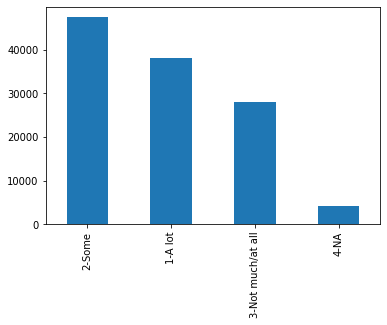

In [6]:
data["confiance_hopital"].value_counts().plot(kind="bar")

In [33]:
# Corrélation entre les indicateurs avec Pandas en enlevant les valeurs absentes
corr = data[["W5{}".format(i) for i in "ABCDEFG"]].replace(99,None).corr()
corr

,W5A,W5B,W5C,W5D,W5E,W5F,W5G
W5A,1.000000,0.207398,0.275820,0.207186,0.280777,0.245285,0.132718
W5B,0.207398,1.000000,0.260237,0.301747,0.306564,0.238801,0.136863
W5C,0.275820,0.260237,1.000000,0.268299,0.404209,0.286795,0.139148
W5D,0.207186,0.301747,0.268299,1.000000,0.274106,0.281237,0.137365
W5E,0.280777,0.306564,0.404209,0.274106,1.000000,0.285606,0.126705
W5F,0.245285,0.238801,0.286795,0.281237,0.285606,1.000000,0.144863
W5G,0.132718,0.136863,0.139148,0.137365,0.126705,0.144863,1.000000


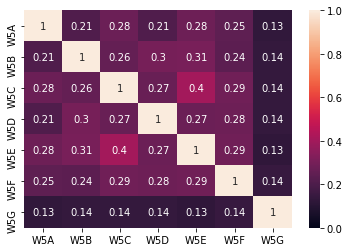

In [34]:
# Le rendre un peu plus joli avec Seaborn
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
import seaborn as sns
heatmap = sns.heatmap(corr, vmin=0, vmax=1, annot=True)

On constate la particularité du dernier indicateur ...

Lien entre les deux questions : on fait un tableau croisé

In [36]:
pd.crosstab(data["confiance_science"],data["confiance_scientifiques"],margins=True)

confiance_scientifiques,1-Beaucoup,2-Un peu,3-Peu ou pas du tout,4-NA,All
confiance_science,,,,,
1-Beaucoup,30015,12835,4368,2060,49278
2-Un peu,11189,25369,7790,3231,47579
3-Peu ou pas du tout,2037,3805,7728,1559,15129
4-NA,1123,1783,1521,2675,7102
All,44364,43792,21407,9525,119088


On peut le représenter sur un tableau croisé

<AxesSubplot:xlabel='confiance_science'>

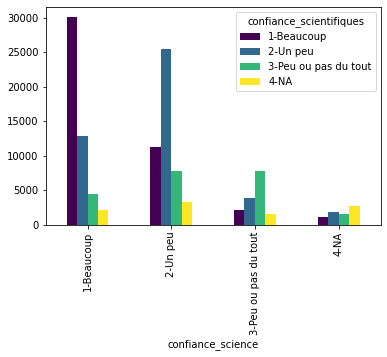

In [40]:
pd.crosstab(data["confiance_science"],data["confiance_scientifiques"]).plot(kind="bar",cmap="viridis")

Cela ne coincide pas exactement. On va donc créer une typologie pour notre analyse :
- confiance dans la science (W4 = 1,2), mais pas confiance dans les scientifiques (W5D=3,4)
- confiance dans les scientifiques, mais pas dans la science (l'inverse)
- pas confiance dans la science ni les scientifiques
- confiance dans les deux
- si une valeur manque, NA

In [45]:
def reco(ligne):
    if (ligne["W4"]==99) | (ligne["W5D"]==99):
        return "NA"
    if (ligne["W4"] in [1,2]) & (ligne["W5D"] in [3,4]):
        return "1-Confiance science mais pas les scientifiques"
    if (ligne["W4"] in [3,4]) & (ligne["W5D"] in [1,2]):
        return "2-Confiance scientifiques mais pas dans la science"
    if (ligne["W4"] in [1,2]) & (ligne["W5D"] in [1,2]):
        return "3-Confiance science"
    if (ligne["W4"] in [3,4]) & (ligne["W5D"] in [3,4]):
        return "4-Méfiance science" 
    
data["confiance_science_scientifiques"] = data.apply(reco,axis=1)
data["confiance_science_scientifiques"].value_counts()

3-Confiance science                                   54007
1-Confiance science mais pas les scientifiques        27039
4-Méfiance science                                    15806
2-Confiance scientifiques mais pas dans la science    10557
NA                                                     9858
Name: confiance_science_scientifiques, dtype: int64

## Etape 3. Production de données statistiques

Dans le cas ici, on a des données qui sont en plus structurées par pays. Il faut donc penser des traitements par pays (par exemple sur la France) et des comparaisons

### Exploration du cas de la France

Construction d'un sous-corpus

In [60]:
data_fr = data[data["pays"].str.contains("France")]
#data_pg = data[data["pays"].str.contains("Paraguay")]

#### Tri à plats

In [48]:
pyshs.tri_a_plat(data_fr,"confiance_science_scientifiques","poids")

,Effectif redressé,Pourcentage (%)
1-Confiance science mais pas les scientifiques,343.9,34.4
2-Confiance scientifiques mais pas dans la science,30.4,3.0
3-Confiance science,582.4,58.2
4-Méfiance science,30.7,3.1
NA,12.6,1.3
Total,1000.0,100.0


In [61]:
tableau = {
    "Confiance Science":pyshs.tri_a_plat(data_fr,"confiance_science","poids"),
    "Confiance Scientifiques":pyshs.tri_a_plat(data_fr,"confiance_scientifiques","poids"),
    "Confiance Hopital":pyshs.tri_a_plat(data_fr,"confiance_hopital","poids"),
    "Confiance Médecins":pyshs.tri_a_plat(data_fr,"confiance_medecins","poids"),
    "Confiance Gouvernement":pyshs.tri_a_plat(data_fr,"confiance_gouvernement","poids"),


}
pd.concat(tableau,axis=1)

Confiance Science                 Confiance Scientifiques  \
                  Effectif redressé Pourcentage (%)       Effectif redressé   
1-A lot                       558.9            55.9                   584.0   
2-Some                        382.2            38.2                   336.5   
3-Not much/at all              52.7             5.3                    73.6   
4-NA                            6.2             0.6                     5.9   
Total                        1000.0           100.0                  1000.0   

                                  Confiance Hopital                  \
                  Pourcentage (%) Effectif redressé Pourcentage (%)   
1-A lot                      58.4             685.1            68.5   
2-Some                       33.6             250.2            25.0   
3-Not much/at all             7.4              61.1             6.1   
4-NA                          0.6               3.7             0.4   
Total                       100.0            1000.1           100.0   

                  Confiance Médecins                 Confiance Gouvernement  \
                   Effectif redressé Pourcentage (%)      Effectif redressé   
1-A lot                        827.9            82.8                  216.7   
2-Some                         141.5            14.2                  346.6   
3-Not much/at all               28.2             2.8                  429.9   
4-NA                             2.4             0.2                    6.8   
Total                         1000.0           100.0                 1000.0   

                                   
                  Pourcentage (%)  
1-A lot                      21.7  
2-Some                       34.7  
3-Not much/at all            43.0  
4-NA                          0.7  
Total                       100.1

In [62]:
pyshs.tri_a_plat(data_fr,"comprendre_science","poids")

,Effectif redressé,Pourcentage (%)
1-A lot,494.3,49.4
2-Some,369.6,37.0
3-Not much/at all,134.9,13.5
4-NA,1.1,0.1
Total,999.9,100.0


In [69]:
pyshs.tri_a_plat(data_fr,"gouvernants_valorisent_scientifiques","poids")

,Effectif redressé,Pourcentage (%)
1-A lot,222.4,22.2
2-Some,472.2,47.2
3-Not much/at all,291.3,29.1
4-NA,14.1,1.4
Total,1000.0,99.9


In [65]:
pyshs.tri_a_plat(data_fr,"recherche_cancer","poids")

,Effectif redressé,Pourcentage (%)
DK/Refused,7.1,0.7
Extremely important,799.3,79.9
Not important at all,3.3,0.3
Not too important,4.1,0.4
Somewhat important,186.2,18.6
Total,1000.0,99.9


In [64]:
tableau = {
    "Apport science à la population":pyshs.tri_a_plat(data_fr,"scientists_benefits_people","poids"),
    "Apport personnel de la science":pyshs.tri_a_plat(data_fr,"scientists_benefits_you","poids")
    }
pd.concat(tableau,axis=1)

Apport science à la population                  \
                    Effectif redressé Pourcentage (%)   
1-Yes                           427.3            42.7   
2-Some                          263.7            26.4   
3-No                            271.8            27.2   
4-NA                             37.1             3.7   
Total                           999.9           100.0   

       Apport personnel de la science                  
                    Effectif redressé Pourcentage (%)  
1-Yes                           372.2            37.2  
2-Some                          500.8            50.1  
3-No                            121.5            12.1  
4-NA                              5.6             0.6  
Total                          1000.1           100.0

### Tableau croisé

In [76]:
var_ind = {"genre":"Genre","age_reco":"Age","socialmedia_month":"Usage Réseaux Sociaux",
           "education":"Diplome","revenus":"Revenus","covid_impact":"Impact du COVID"}

Rapport Science/politique

In [77]:
pyshs.tableau_croise_multiple(data_fr,"gouvernants_valorisent_scientifiques",var_ind,"poids")

1-A lot  \
Variable                          Modalités                                             
Genre (p = 0.029)                 1-Male                                118.4 (23.5%)   
                                  2-Female                              104.0 (21.0%)   
                                  Total                                 222.4 (22.2%)   
Age (p = 0.084)                   1-[15-35[                              47.5 (17.0%)   
                                  2-[35-45[                              41.6 (25.3%)   
                                  3-[45-55[                              35.9 (18.7%)   
                                  4-[55-65[                              36.9 (26.4%)   
                                  5-[65-75]                              60.5 (26.9%)   
                                  Total                                 222.4 (22.2%)   
Usage Réseaux Sociaux (p = 0.899) No                                     70.0 (22.7%)   
                                  Yes                                   152.3 (22.0%)   
                                  Total                                 222.4 (22.2%)   
Diplome (p = 0.759)               Elementary or less (8 years or less)   29.4 (27.0%)   
                                  Secondary (8-15 years)                159.3 (21.8%)   
                                  Tertiary (16+ years)                   33.7 (21.2%)   
                                  Total                                 222.4 (22.2%)   
Revenus (p = 0.247)               Q1                                     36.9 (18.6%)   
                                  Q2                                     48.4 (24.1%)   
                                  Q3                                     42.7 (21.3%)   
                                  Q4                                     47.0 (23.5%)   
                                  Q5                                     47.3 (23.6%)   
                                  Total                                 222.4 (22.2%)   
Impact du COVID (p = 0.365)       (DK)                                     0.0 (0.0%)   
                                  A lot                                  81.1 (26.4%)   
                                  Not at all                             49.9 (23.5%)   
                                  Some                                   91.4 (19.0%)   
                                  Total                                 222.4 (22.2%)   

                                                                               2-Some  \
Variable                          Modalités                                             
Genre (p = 0.029)                 1-Male                                228.5 (45.3%)   
                                  2-Female                              243.7 (49.2%)   
                                  Total                                 472.2 (47.2%)   
Age (p = 0.084)                   1-[15-35[                             142.6 (51.1%)   
                                  2-[35-45[                              72.1 (43.9%)   
                                  3-[45-55[                              85.5 (44.6%)   
                                  4-[55-65[                              62.3 (44.6%)   
                                  5-[65-75]                             109.6 (48.7%)   
                                  Total                                 472.2 (47.2%)   
Usage Réseaux Sociaux (p = 0.899) No                                    140.2 (45.5%)   
                                  Yes                                   332.1 (48.0%)   
                                  Total                                 472.2 (47.2%)   
Diplome (p = 0.759)               Elementary or less (8 years or less)   48.2 (44.3%)   
                                  Secondary (8-15 years)                346.6 (47.3%)   
                                  Tertiary (16+ years)                  

Pas de grosses variations

In [78]:
pyshs.tableau_croise_multiple(data_fr,"confiance_hopital",var_ind,"poids")

1-A lot  \
Variable                          Modalités                                             
Genre (p = 0.004)                 1-Male                                368.2 (73.0%)   
                                  2-Female                              316.8 (63.9%)   
                                  Total                                 685.1 (68.5%)   
Age (p = 0.551)                   1-[15-35[                             184.8 (66.1%)   
                                  2-[35-45[                             108.6 (66.1%)   
                                  3-[45-55[                             132.8 (69.3%)   
                                  4-[55-65[                             105.8 (75.7%)   
                                  5-[65-75]                             153.1 (68.1%)   
                                  Total                                 685.1 (68.5%)   
Usage Réseaux Sociaux (p = 0.953) No                                    214.5 (69.5%)   
                                  Yes                                   470.6 (68.0%)   
                                  Total                                 685.1 (68.5%)   
Diplome (p = 0.127)               Elementary or less (8 years or less)   71.2 (65.4%)   
                                  Secondary (8-15 years)                506.0 (69.1%)   
                                  Tertiary (16+ years)                  107.9 (67.9%)   
                                  Total                                 685.1 (68.5%)   
Revenus (p = 0.507)               Q1                                    122.3 (61.5%)   
                                  Q2                                    143.6 (71.7%)   
                                  Q3                                    137.8 (68.8%)   
                                  Q4                                    144.1 (72.0%)   
                                  Q5                                    137.3 (68.6%)   
                                  Total                                 685.1 (68.5%)   
Impact du COVID (p = 0.145)       (DK)                                   0.8 (100.0%)   
                                  A lot                                 221.3 (72.2%)   
                                  Not at all                            155.4 (73.2%)   
                                  Some                                  307.6 (64.0%)   
                                  Total                                 685.1 (68.5%)   

                                                                               2-Some  \
Variable                          Modalités                                             
Genre (p = 0.004)                 1-Male                                108.2 (21.5%)   
                                  2-Female                              141.9 (28.6%)   
                                  Total                                 250.2 (25.0%)   
Age (p = 0.551)                   1-[15-35[                              78.4 (28.1%)   
                                  2-[35-45[                              44.1 (26.8%)   
                                  3-[45-55[                              40.3 (21.0%)   
                                  4-[55-65[                              27.4 (19.6%)   
                                  5-[65-75]                              59.9 (26.6%)   
                                  Total                                 250.2 (25.0%)   
Usage Réseaux Sociaux (p = 0.953) No                                     75.0 (24.3%)   
                                  Yes                                   175.2 (25.3%)   
                                  Total                                 250.2 (25.0%)   
Diplome (p = 0.127)               Elementary or less (8 years or less)   25.0 (23.0%)   
                                  Secondary (8-15 years)                188.5 (25.7%)   
                                  Tertiary (16+ years)                  

Effet du genre

#### Petit visualisation

Text(0.5, 0.98, 'Confiance des répondants du pays')

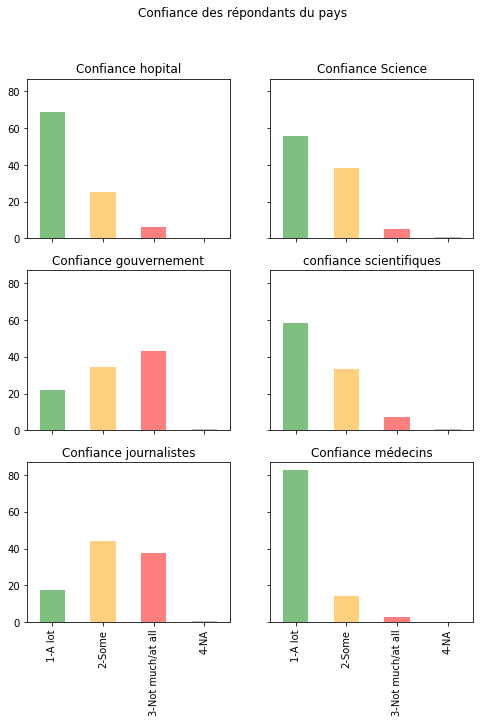

In [91]:
# Définir en amont les variables
variables = {"confiance_hopital":"Confiance hopital","confiance_science":"Confiance Science",
            "confiance_gouvernement":"Confiance gouvernement","confiance_scientifiques":"confiance scientifiques",
            "confiance_journalistes":"Confiance journalistes","confiance_medecins":"Confiance médecins"}

# Définir une nouvelle figure
fig,ax = plt.subplots(3,2,figsize=(8,10),sharex=True,sharey=True)

# passer le tableau de 2 dimensions à 1
ax = ax.flatten()

# Pour chaque variable à tracer
for i,j in zip(variables,range(0,len(variables))):
    t = pyshs.tri_a_plat(data_fr,i,"poids")["Pourcentage (%)"].drop("Total")
    t.plot(kind='bar',ax=ax[j],color = ["Green","orange","red","gray"],alpha=0.5)
    ax[j].set_title(variables[i])
    
fig.suptitle("Confiance des répondants du pays")

#### Par pays, afficher la confiance à l'hopital

<AxesSubplot:ylabel='pays'>

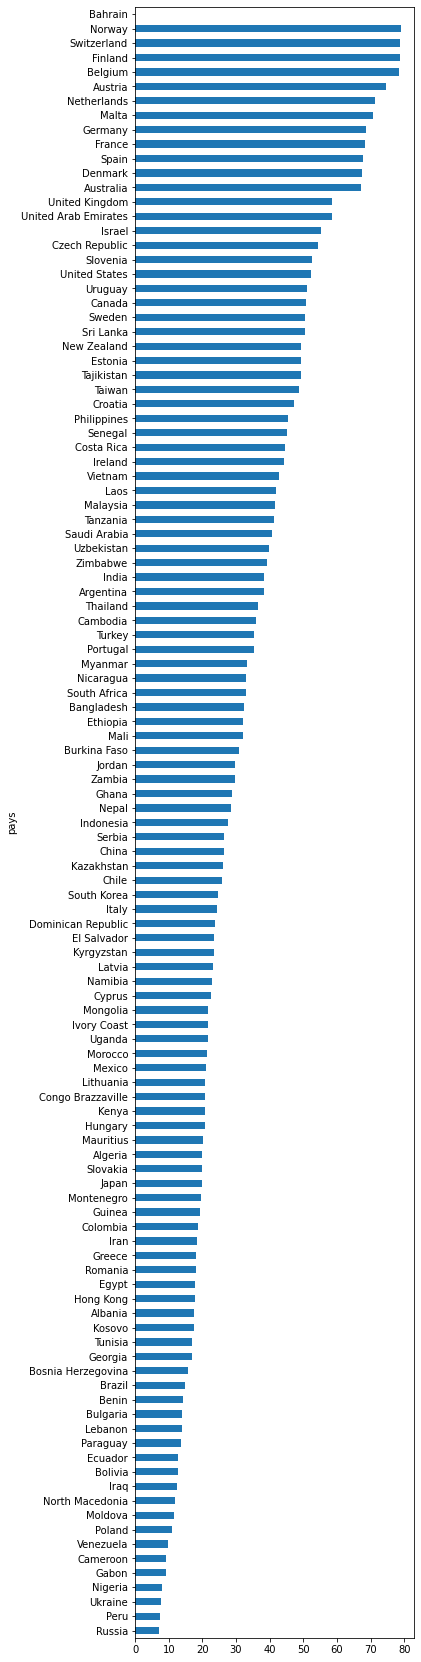

In [139]:
# Construire une fonction dédiée qui traite un tableau pandas
def prop_lot(x):
    t = pyshs.tri_a_plat(x,"confiance_hopital","poids")
    try:
        return t.loc["1-A lot","Pourcentage (%)"]
    except:
        return None

# L'appliquer à la sortie d'un groupby, trier et afficher
data.groupby("pays").apply(prop_lot).sort_values().plot(kind="barh",figsize=(5,30))

## Analyse statistique plus avancée

Suivant votre spécialité, vous aimeriez faire des traitements. En tant que sociologue, je serai intéressé à connaître les principaux déterminants sur certaines variables d'intérêts, par exemple le fait de penser que les gouvernants valorise l'expertise des scientifiques. Une solution est de faire une régression logistique. Plusieurs solutions pour cela : passer par la bibliothèque statsmodels, ou utiliser le wrapper de pyshs pour obtenir un tableau rapidement

Créer une variable dichotomisée dépendante 1/0

In [220]:
data["valo_sci_dich"] = data["gouvernants_valorisent_scientifiques"].apply(lambda x : 1 if x=="1-A lot" else 0)

Définir nos variables indépendantes

In [221]:
var_ind = {"genre":"Genre","age_reco":"Age","revenus":"Revenus","education":"Education",
            "comprendre_science":"Compréhension de la science","covid_impact":"Impacté par le COVID",
            "scientists_benefits_people":"Science bénéfique aux gens","socialmedia_freq":"Usage des réseaux sociaux"}

Cas de la France

In [223]:
pyshs.regression_logistique(data[data["pays"]=="France"],"valo_sci_dich",var_ind,"poids")

Odds Ratio  \
Variable                    Modalité                                          
.Intercept                                                             0.64   
Age                         1-[15-35[                                   ref   
                            2-[35-45[                                  1.25   
                            3-[45-55[                                  0.97   
                            4-[55-65[                                  1.41   
                            5-[65-75]                                  1.45   
Compréhension de la science 1-A lot                                     ref   
                            2-Some                                     0.72   
                            3-Not much/at all                          1.22   
                            4-NA                                          1   
Education                   Elementary or less (8 years or less)        ref   
                            Secondary (8-15 years)                     0.79   
                            Tertiary (16+ years)                       0.66   
Genre                       1-Male                                      ref   
                            2-Female                                    0.7   
Impacté par le COVID        1-A lot                                     ref   
                            2-Some                                     0.57   
                            3-DK                                          1   
                            3-Not much/at all                          0.75   
Revenus                     Q1                                          ref   
                            Q2                                         1.61   
                            Q3                                         1.17   
                            Q4                                         1.12   
                            Q5                                         1.62   
Science bénéfique aux gens  1-Yes                                       ref   
                            2-Some                                     0.61   
                            3-No                                       0.51   
                            4-NA                                       2.32   
Usage des réseaux sociaux   1-Almost every hour                         ref   
                            2-At least once a day                      0.74   
                            3-A few days a week                        0.92   
                            4-Less frequently                          0.73   
                            5-DK/Refused                               0.66   

                                                                        p  \
Variable                    Modalité                                        
.Intercept                                                          0.376   
Age                         1-[15-35[                                       
                            2-[35-45[                                0.44   
                            3-[45-55[                               0.915   
                            4-[55-65[                               0.292   
                            5-[65-75]                               0.189   
Compréhension de la science 1-A lot                                         
                            2-Some                                  0.133   
                            3-Not much/at all                        0.48   
                            4-NA                                    0.789   
Education                   Elementary or less (8 years or less)            
                            Secondary (8-15 years)                  0.465   
                            Tertiary (16+ years)                    0.285   
Genre                       1-Male                                          
                            2-Female                               

Le monde entier (petit nombre de variable, car les autres ne sont pas nettoyées)

In [226]:
var_ind = {"genre":"Genre","age_reco":"Age"}
pyshs.regression_logistique(data,"valo_sci_dich",var_ind,"poids")

Odds Ratio       p            IC 95%
Variable   Modalité                                      
.Intercept                 0.24  0.0***  0.24 [0.24-0.25]
Age        1-[15-35[        ref                          
           2-[35-45[       0.96   0.061  0.96 [0.92-1.00]
           3-[45-55[        1.1  0.0***  1.10 [1.05-1.14]
           4-[55-65[       1.06  0.027*  1.06 [1.01-1.11]
           5-[65-75]       1.05    0.07  1.05 [1.00-1.10]
Genre      1-Male           ref                          
           2-Female        0.94  0.0***  0.94 [0.92-0.97]

## Représentations géographiques

Pour cela on utilise GéoPandas

Il faut un fond de carte, généralement en shapefiles : https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/

In [140]:
import geopandas as gpd

In [142]:
carte = gpd.read_file("./world-administrative-boundaries/world-administrative-boundaries.shp")

Vérifions que le nom des pays est écrit de la même manière dans le jeu de données et dans la carte

In [148]:
noms_cartes = carte["name"].unique()
noms_data = data["COUNTRYNEW"].unique()

for i in noms_data:
    if not i in noms_cartes:
        print(i)

United States
United Kingdom
Iran
Tanzania
Laos
South Korea
Moldova
Russia
Bosnia Herzegovina
Congo Brazzaville
Ivory Coast
North Macedonia
Kosovo


Ce sont les noms qu'il faut relier, donc on va créer un dictionnaire de correspondances et créer une nouvelle colonne avec les noms recodées

In [150]:
reco = {   "United States":'United States of America',
    "United Kingdom":'U.K. of Great Britain and Northern Ireland',
    "Iran":'Iran (Islamic Republic of)',
    "Tanzania":'United Republic of Tanzania',
     "South Korea":'Republic of Korea',
     'Moldova':'Moldova, Republic of',
     "Russia":'Russian Federation',
     "Bosnia Herzegovina":'Bosnia & Herzegovina',
     "Congo Brazzaville":'Democratic Republic of the Congo',
     "North Macedonia":'The former Yugoslav Republic of Macedonia'
    }

# reste à faire Kosovo et Ivory Coast
data["pays_reco"] = data["pays"].replace(reco) 

Il est possible maintenant de créer des données par pays à partir du sondage

In [157]:
data_pays = pd.DataFrame(data.groupby("pays_reco").apply(prop_lot),columns=["Confiance hopital"])

Et de les associer à la carte

In [160]:
carte_data = carte.join(data_pays,on="name")

Pour construire une visualisation (plus de détail par exemple sur  https://geopandas.org/en/stable/docs/user_guide/mapping.html)

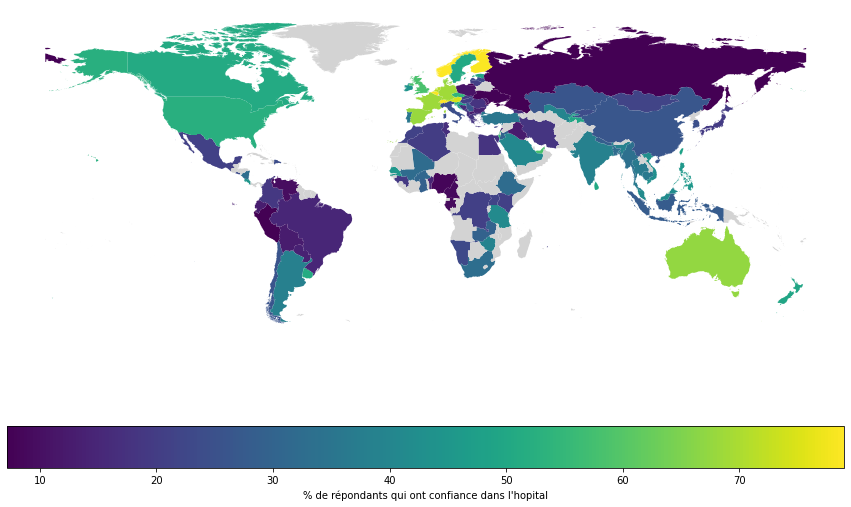

In [175]:
ax = carte_data.plot(column='Confiance hopital',figsize=(15,10),legend=True,
                legend_kwds={'label': "% de répondants qui ont confiance dans l'hopital",
                             'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
ax.set_axis_off()

Une deuxième carte sur l'impression que la science apporte des bénéfices directe aux répondants

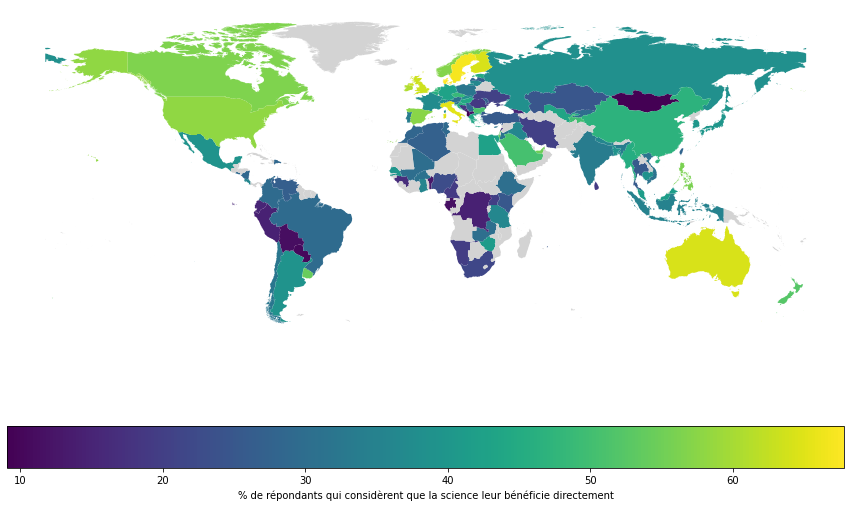

In [180]:
# Construire une fonction dédiée qui traite un tableau pandas
def prop_conf(x):
    t = pyshs.tri_a_plat(x,"scientists_benefits_you","poids")
    try:
        return t.loc['1-Yes',"Pourcentage (%)"]
    except:
        return None

# L'appliquer à la sortie d'un groupby, trier et afficher
data_pays = pd.DataFrame(data.groupby("pays_reco").apply(prop_conf),columns=["Apport science"])

# Ajouter au jeu de données
carte_data = carte.join(data_pays,on="name")

# Construire la carte
ax = carte_data.plot(column='Apport science',figsize=(15,10),legend=True,
                legend_kwds={'label': "% de répondants qui considèrent que la science leur bénéficie directement",
                             'orientation': "horizontal"}, missing_kwds={'color': 'lightgrey'})
ax.set_axis_off()

Après cela, rien n'empêche de prolonger avec des analyses plus complexes...

Etape suivante à réaliser : intégrer les widgets avec https://github.com/jupyter-widgets/ipyleaflet